In [1]:
import os
from pathlib import Path

import crystal_toolkit  # noqa: F401
from pymatgen.core import Structure

In [2]:
# Load a structure from a CIF or POSCAR file

batch_name = "bandgap3.5b1"
batch_path = "../matter"
cif_name = "gen_8"
cif_path = os.path.abspath(
    os.path.join(batch_path, batch_name, "extracted", f"{cif_name}.cif")
)

print(f"Loading {cif_path}")

struct_expt = Structure.from_file(cif_path)
struct_expt

Loading d:\Projects\Sim\matsimx\matter\bandgap3.5b1\extracted\gen_8.cif


d:\Projects\Sim\matsimx\.venv\lib\site-packages\crystal_toolkit\core\jupyter.py:55: UserWarning:

Port {port} not available, using {free_port} instead.



In [3]:
# Create output directory based on reduced formula
# get reduced formula

reduced_formula = struct_expt.composition.reduced_formula
print(f"Reduced formula: {reduced_formula}")

output_dir = f"{batch_name}-{cif_name}-{reduced_formula}"

# mkdir in output folder named reduced_formula
os.makedirs(f"output/{output_dir}", exist_ok=True)

Reduced formula: TbHI


## pbe

In [4]:
# Relax with pbe

import matcalc

calculator_pbe = matcalc.load_fp("pbe")
relax_calc = matcalc.RelaxCalc( # type: ignore
    calculator_pbe,
    optimizer="FIRE",
    relax_atoms=True,
    relax_cell=True
)

data = relax_calc.calc(struct_expt)

final_structure_pbe = data['final_structure']
print(final_structure_pbe)
final_structure_pbe.to(fmt="poscar", filename=f"output/{output_dir}/POSCAR-pbe")

Full Formula (Tb2 H2 I2)
Reduced Formula: TbHI
abc   :   3.902864   3.902276   9.885373
angles:  89.925989  89.995211  89.889722
pbc   :       True       True       True
Sites (6)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Tb    0.566848  0.564427  0.652066
  1  Tb    0.067004  0.065197  0.401055
  2  H     0.066772  0.564935  0.52611
  3  H     0.567034  0.064736  0.526094
  4  I     0.567048  0.565444  0.221842
  5  I     0.066978  0.064011  0.830863


'Tb2 H2 I2\n1.0\n   3.9028640066524556   -0.0010583603359071    0.0005311529347083\n   0.0085681951042269    3.9022624773621306    0.0057264722739333\n  -0.0005195792937666   -0.0017360286209032    9.8853724483777281\nTb H I\n2 2 2\ndirect\n   0.5668480178322972    0.5644271888817678    0.6520662428326814 Tb\n   0.0670044462361047    0.0651965060883800    0.4010554243576953 Tb\n   0.0667721319351917    0.5649346689278170    0.5261100256411851 H\n   0.5670337258644300    0.0647362381296529    0.5260937980936943 H\n   0.5670478750198792    0.5654440726870203    0.2218420573555490 I\n   0.0669783834225570    0.0640106862673716    0.8308628879966261 I\n'

In [5]:
phonon_calc = matcalc.PhononCalc(  # type: ignore
    calculator_pbe,
    relax_structure=True,
    write_band_structure=f"output/{output_dir}/pbe_phonon_bs.yaml",
    write_total_dos=f"output/{output_dir}/pbe_phonon_dos.dat",
    write_phonon=f"output/{output_dir}/pbe_phonon.yaml",
    optimizer="FIRE",
)

data_phonon_pbe = phonon_calc.calc(final_structure_pbe)

d:\Projects\Sim\matsimx\.venv\lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning:

dict interface is deprecated. Use attribute interface instead



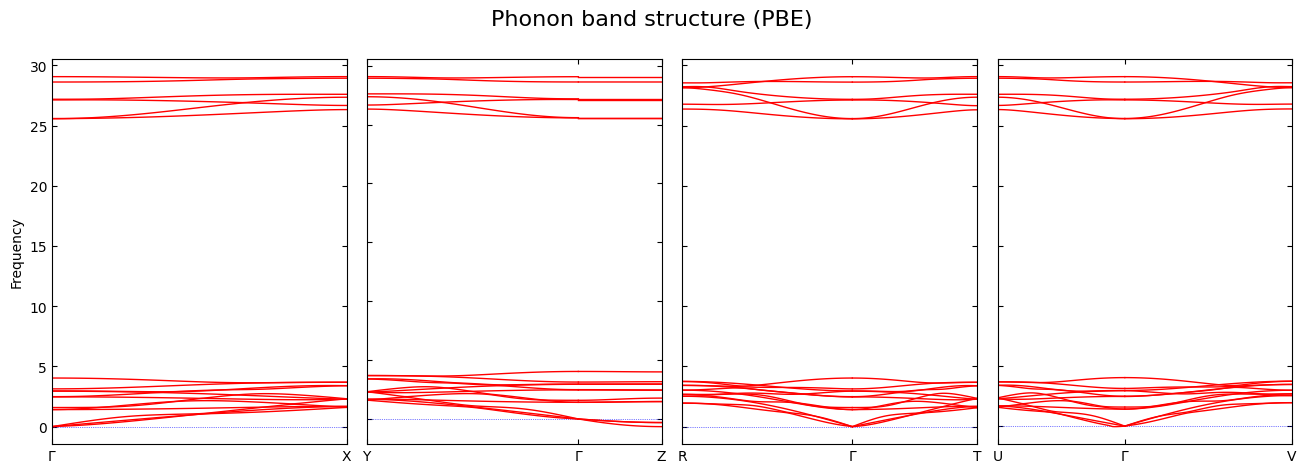

In [6]:
import matplotlib.pyplot as plt

phonon_bs = data_phonon_pbe["phonon"].band_structure

n_axes = sum(1 for c in phonon_bs.path_connections if not c)

fig, axs = plt.subplots(1, n_axes, figsize=(16, 5))

if n_axes == 1:
    axs = [axs]

for ax in axs[1:]:
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelleft=False)

phonon_bs.plot(ax=axs)
fig.suptitle("Phonon band structure (PBE)", fontsize=16)
plt.subplots_adjust(wspace=0.07)

# Save figure
fig.savefig(f"output/{output_dir}/pbe_phonon_band.png", dpi=300, bbox_inches="tight")

plt.show()

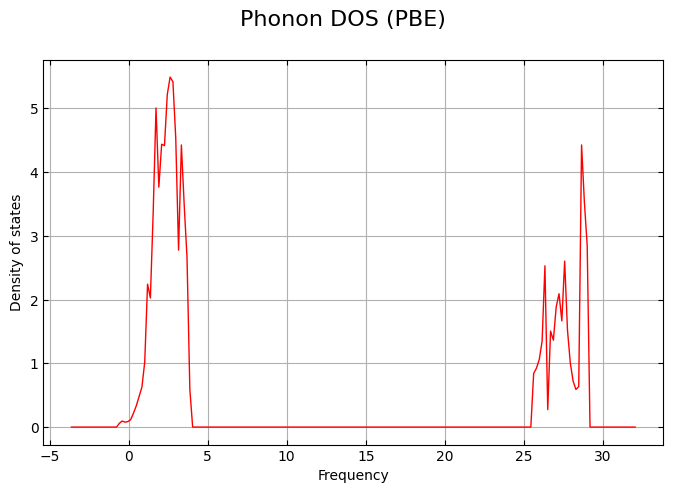

In [7]:
phonon_dos = data_phonon_pbe["phonon"].total_dos

fig, ax = plt.subplots(figsize=(8, 5))
phonon_dos.plot(ax=ax)
fig.suptitle("Phonon DOS (PBE)", fontsize=16)

# Save figure
fig.savefig(f"output/{output_dir}/pbe_phonon_dos.png", dpi=300, bbox_inches="tight")
plt.show()

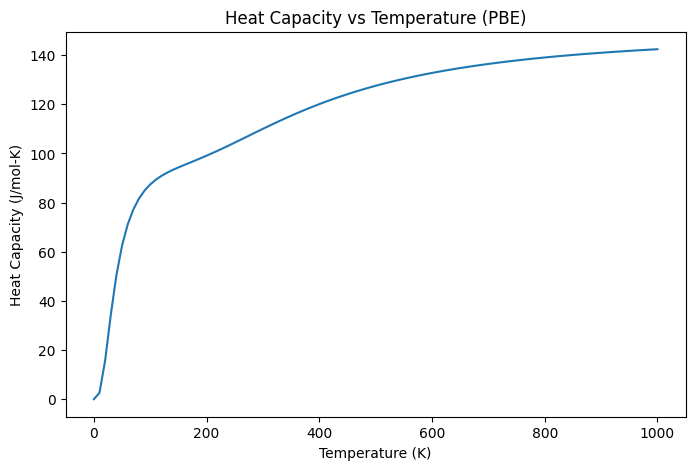

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    data_phonon_pbe["thermal_properties"]["temperatures"],
    data_phonon_pbe["thermal_properties"]["heat_capacity"],
)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Heat Capacity (J/mol-K)")
ax.set_title("Heat Capacity vs Temperature (PBE)")

# Save figure
fig.savefig(f"output/{output_dir}/pbe_heat_capacity.png", dpi=300, bbox_inches="tight")
plt.show()

## r2scan

In [9]:
# Relax with r2scan

import matcalc

calculator_r2scan = matcalc.load_fp("r2scan")
relax_calc = matcalc.RelaxCalc( # type: ignore
    calculator_r2scan, optimizer="FIRE", relax_atoms=True, relax_cell=True
)

data_r2scan = relax_calc.calc(struct_expt)

final_structure_r2scan = data_r2scan["final_structure"]
print(final_structure_r2scan)
final_structure_r2scan.to(fmt="poscar", filename=f"output/{output_dir}/POSCAR-r2scan")

Full Formula (Tb2 H2 I2)
Reduced Formula: TbHI
abc   :   3.856921   3.855964   9.853665
angles:  89.914979  89.991330  89.877938
pbc   :       True       True       True
Sites (6)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Tb    0.566848  0.564395  0.651172
  1  Tb    0.067032  0.0651    0.401016
  2  H     0.066686  0.565148  0.526255
  3  H     0.567052  0.064664  0.526288
  4  I     0.567005  0.565208  0.22752
  5  I     0.067062  0.064235  0.825779


'Tb2 H2 I2\n1.0\n   3.8569210552007931   -0.0006498864017887    0.0006579027878458\n   0.0088633632609538    3.8559494112469861    0.0060539608165850\n  -0.0001899758601630   -0.0008481880657561    9.8536645407302625\nTb H I\n2 2 2\ndirect\n   0.5668484665636547    0.5643946106044317    0.6511720486764087 Tb\n   0.0670316568393825    0.0651004030221423    0.4010160167644676 Tb\n   0.0666859828735554    0.5651482564917870    0.5262554318972034 H\n   0.5670520952377127    0.0646635121685039    0.5262875903244103 H\n   0.5670045649549882    0.5652079082558962    0.2275202232598240 I\n   0.0670618158475184    0.0642346706433405    0.8257791243272699 I\n'

In [10]:
phonon_calc = matcalc.PhononCalc(  # type: ignore
    calculator_r2scan,
    relax_structure=True,
    write_band_structure=f"output/{output_dir}/r2scan_phonon_bs.yaml",
    write_total_dos=f"output/{output_dir}/r2scan_phonon_dos.dat",
    write_phonon=f"output/{output_dir}/r2scan_phonon.yaml",
    optimizer="FIRE",
)

data_phonon_r2scan = phonon_calc.calc(final_structure_r2scan)

d:\Projects\Sim\matsimx\.venv\lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning:

dict interface is deprecated. Use attribute interface instead



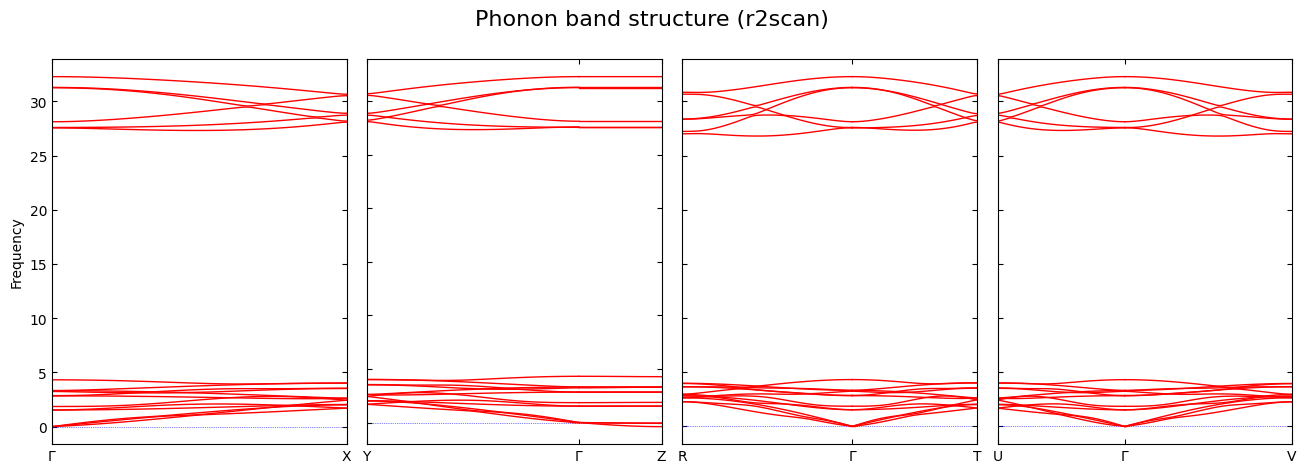

In [11]:
import matplotlib.pyplot as plt

phonon_bs = data_phonon_r2scan["phonon"].band_structure

n_axes = sum(1 for c in phonon_bs.path_connections if not c)

fig, axs = plt.subplots(1, n_axes, figsize=(16, 5))

if n_axes == 1:
    axs = [axs]

for ax in axs[1:]:
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelleft=False)

phonon_bs.plot(ax=axs)
fig.suptitle("Phonon band structure (r2scan)", fontsize=16)
plt.subplots_adjust(wspace=0.07)

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_phonon_band.png", dpi=300, bbox_inches="tight")
plt.show()

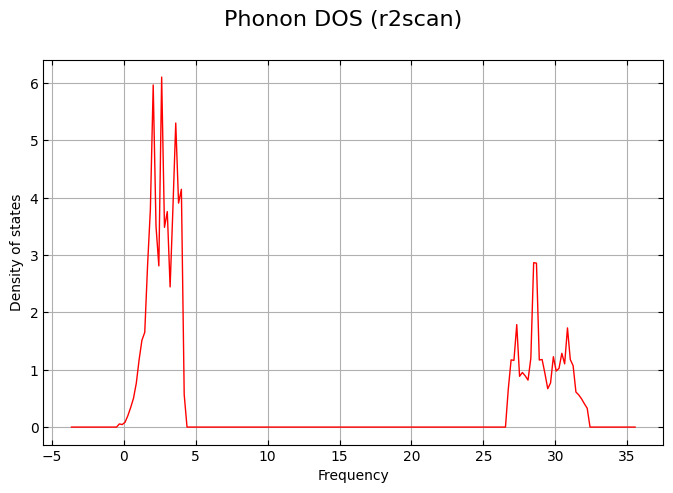

In [12]:
phonon_dos = data_phonon_r2scan["phonon"].total_dos

fig, ax = plt.subplots(figsize=(8, 5))
phonon_dos.plot(ax=ax)
fig.suptitle("Phonon DOS (r2scan)", fontsize=16)

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_phonon_dos.png", dpi=300, bbox_inches="tight")
plt.show()

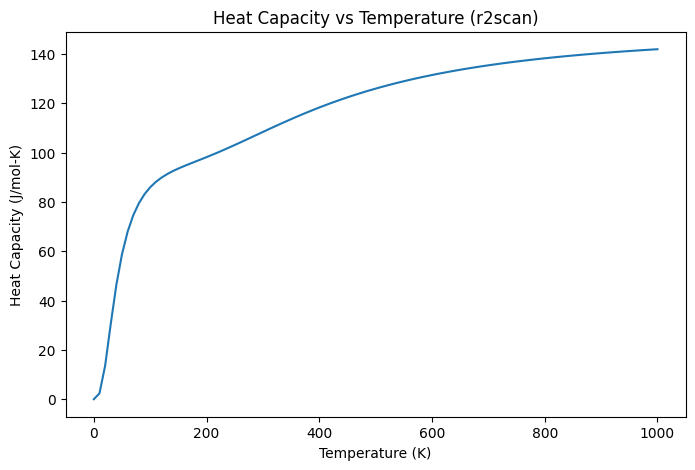

In [13]:
# Heat capacity for r2scan
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    data_phonon_r2scan['thermal_properties']['temperatures'],
    data_phonon_r2scan['thermal_properties']['heat_capacity']
)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel('Heat Capacity (J/mol-K)')
ax.set_title("Heat Capacity vs Temperature (r2scan)")

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_heat_capacity.png", dpi=300, bbox_inches="tight")
plt.show()

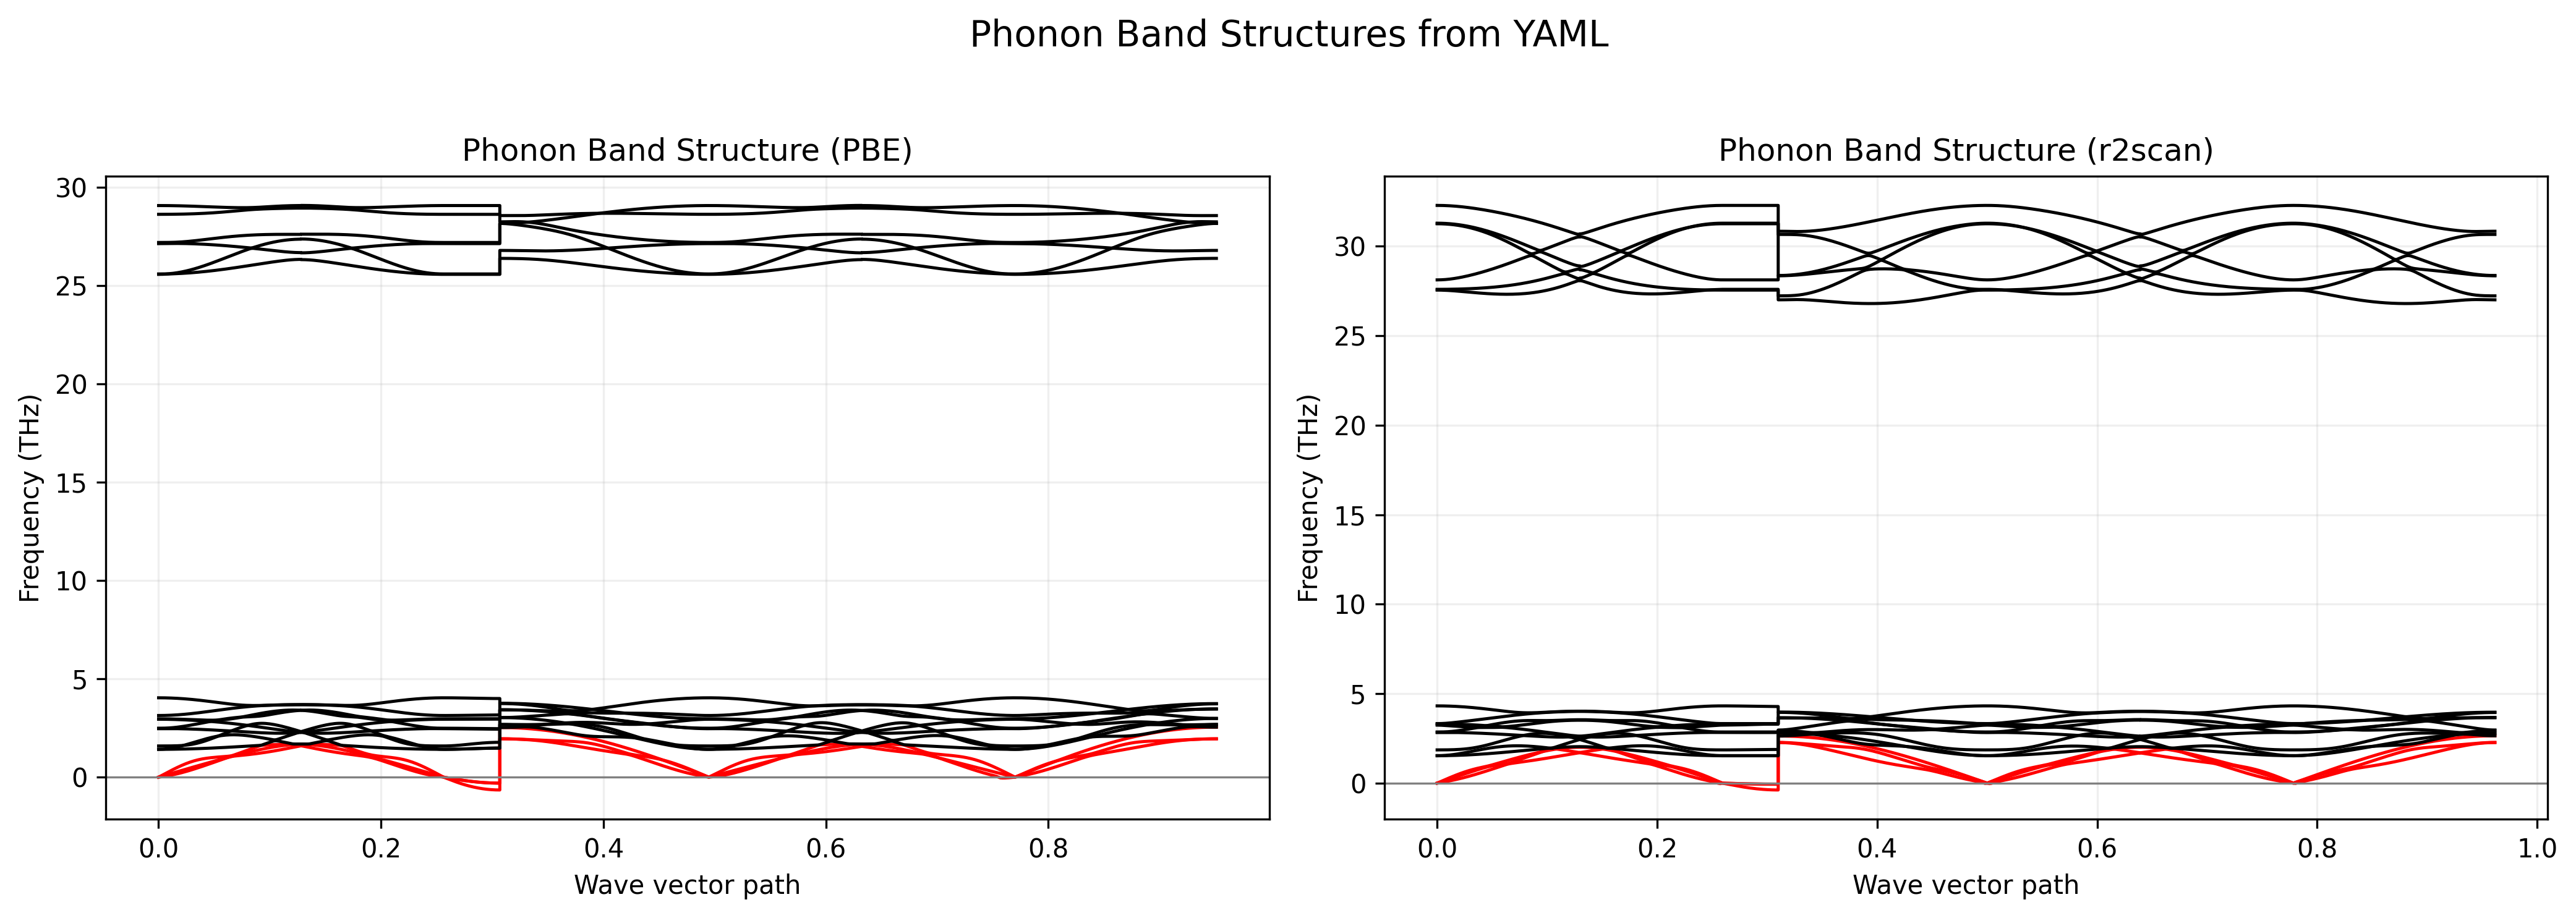

PBE min frequency: -0.651 THz -> unstable (imaginary)
r2scan min frequency: -0.380 THz -> unstable (imaginary)


In [15]:
import yaml
import numpy as np
import matplotlib.pyplot as plt


def plot_phonon_band_yaml(ax, band_yaml_file, title=None):
    """
    Plot phonon dispersion directly from band.yaml onto the provided Axes.
    Imaginary frequencies are shown in red.
    Returns the minimum frequency (THz).
    """
    with open(band_yaml_file, "r") as f:
        data = yaml.safe_load(f)

    q_distances = []
    frequencies = []

    for point in data["phonon"]:
        q_distances.append(point["distance"])
        freqs = [band["frequency"] for band in point["band"]]
        frequencies.append(freqs)

    q_distances = np.array(q_distances)
    frequencies = np.array(frequencies)

    for i in range(frequencies.shape[1]):
        freq_branch = frequencies[:, i]
        ax.plot(
            q_distances,
            freq_branch,
            color="red" if np.any(freq_branch < 0) else "black",
            lw=1.2,
        )

    ax.axhline(0, color="gray", lw=0.8)
    ax.set_xlabel("Wave vector path")
    ax.set_ylabel("Frequency (THz)")
    if title:
        ax.set_title(title)
    ax.grid(alpha=0.2)

    return float(np.min(frequencies))


# Paths from earlier blocks
pbe_band_file = f"output/{output_dir}/pbe_phonon_bs.yaml"
r2scan_band_file = f"output/{output_dir}/r2scan_phonon_bs.yaml"

# Side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 5), dpi=300)

min_pbe = plot_phonon_band_yaml(
    axs[0], pbe_band_file, title="Phonon Band Structure (PBE)"
)
min_r2 = plot_phonon_band_yaml(
    axs[1], r2scan_band_file, title="Phonon Band Structure (r2scan)"
)

fig.suptitle("Phonon Band Structures from YAML", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save combined figure
fig.savefig(
    f"output/{output_dir}/phonon_band_PBE_vs_r2scan.png", dpi=300, bbox_inches="tight"
)
plt.show()

# Stability messages
print(
    f"PBE min frequency: {min_pbe:.3f} THz -> {'unstable (imaginary)' if min_pbe < 0 else 'stable'}"
)
print(
    f"r2scan min frequency: {min_r2:.3f} THz -> {'unstable (imaginary)' if min_r2 < 0 else 'stable'}"
)

In [16]:
# Append a compact summary line for this sample:
# structure_name, reduced_formula, spacegroup, stable|unstable

import os
import yaml
import numpy as np


def min_freq_from_band_yaml(band_yaml_file: str) -> float | None:
    try:
        with open(band_yaml_file, "r") as f:
            data = yaml.safe_load(f)
        freqs = np.array([[b["frequency"] for b in p["band"]] for p in data["phonon"]])
        return float(np.min(freqs))
    except Exception:
        return None


# Choose a structure name for logging (use your CIF name or any identifier you prefer)
structure_name = cif_name  # or f"{batch_name}-{cif_name}"

# Prefer space group from relaxed r2scan structure, then PBE, then experimental
try:
    sgsym, sgnum = final_structure_r2scan.get_space_group_info()
    ref_structure = "r2scan"
except Exception:
    try:
        sgsym, sgnum = final_structure_pbe.get_space_group_info()
        ref_structure = "pbe"
    except Exception:
        sgsym, sgnum = struct_expt.get_space_group_info()
        ref_structure = "expt"

spacegroup_str = f"{sgsym} (#{sgnum})"

# Decide stability: prefer r2scan band.yaml if present, else PBE
pbe_band_file = f"output/{output_dir}/pbe_phonon_bs.yaml"
r2_band_file = f"output/{output_dir}/r2scan_phonon_bs.yaml"

min_r2 = min_freq_from_band_yaml(r2_band_file) if os.path.exists(r2_band_file) else None
min_pbe = (
    min_freq_from_band_yaml(pbe_band_file) if os.path.exists(pbe_band_file) else None
)

# Use r2scan if available, else PBE
chosen_min = min_r2 if min_r2 is not None else min_pbe
stable = (chosen_min is not None) and (chosen_min >= -1e-4)  # small tolerance

# Append one line to a global summary file
summary_path = os.path.join("output", "samples_summary.txt")
os.makedirs(os.path.dirname(summary_path), exist_ok=True)

line = f"{structure_name}\t{reduced_formula}\t{spacegroup_str}\t{'stable' if stable else 'unstable'}\n"
with open(summary_path, "a", encoding="utf-8") as f:
    f.write(line)

print(f"Appended to {summary_path}: {line.strip()}")

Appended to output\samples_summary.txt: gen_8	TbHI	P4mm (#99)	unstable
